# Import Library

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Activation and Loss Function

In [106]:
def relu(z):
    return np.maximum(0, z)

def mse(true, pred):
    return np.mean((pred - true) ** 2)

# Derivative of Activation and Loss Function

In [107]:
def relu_derivative(z):
    return (z > 0).astype(float)

def mse_derivative(true, pred):
    return 2 * (pred - true) / true.size

# MLP Code

In [108]:
class MLP:
    def __init__(self, input_dimension, hidden_dimension, output_dimension, learning_rate):
        self.learning_rate = learning_rate

        self.weight_input_hidden = np.random.randn(input_dimension, hidden_dimension) * 0.01
        self.weight_hidden_output = np.random.randn(hidden_dimension, output_dimension) * 0.01

        self.bias_hidden = np.zeros((1, hidden_dimension))
        self.bias_output = np.zeros((1, output_dimension))

    def forward_propagation(self, x):
        self.x = x
        self.hidden_layer_input = np.dot(x, self.weight_input_hidden) + self.bias_hidden
        self.hidden_layer_output = relu(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weight_hidden_output) + self.bias_output
        self.output = self.output_layer_input
        return self.output
    
    def backward_propagation(self, y_true, y_pred):
        d_output_layer_input = mse_derivative(y_true, y_pred)

        d_weight_hidden_output = np.dot(self.hidden_layer_output.T, d_output_layer_input)
        d_bias_output = np.sum(d_output_layer_input, axis=0, keepdims=True)

        d_hidden_layer_output = np.dot(d_output_layer_input, self.weight_hidden_output.T)
        d_hidden_layer_input = d_hidden_layer_output * relu_derivative(self.hidden_layer_input)

        d_weight_input_hidden = np.dot(self.x.T, d_hidden_layer_input)
        d_bias_hidden = np.sum(d_hidden_layer_input, axis=0, keepdims=True)

        self.weight_input_hidden -= self.learning_rate * d_weight_input_hidden
        self.weight_hidden_output -= self.learning_rate * d_weight_hidden_output
        self.bias_hidden -= self.learning_rate * d_bias_hidden
        self.bias_output -= self.learning_rate * d_bias_output

    def train(self, x, y, epochs):
        loss_list = []
        for epoch in range(epochs):
            y_pred = self.forward_propagation(x)
            loss = mse(y, y_pred)
            loss_list.append(loss)
            self.backward_propagation(y, y_pred)     
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
        return loss_list, y_pred
    
    def evaluate(self, x, y):
        y_pred = self.forward_propagation(x)
        loss = mse(x, y)
        return loss, y_pred

# Load Data

In [120]:
file_path = '../../Datasets/조업편차분석.csv'
data = pd.read_csv(file_path)

# Extracting X, Y and # Splitting into Train and Test Datasets

In [110]:
shuffled_data = data.sample(frac=1, random_state=42)
train_size = int(len(shuffled_data) * 0.8)

train_data = shuffled_data.iloc[:train_size]
test_data = shuffled_data.iloc[train_size:]

x_train, y_train = train_data.drop(columns=["No.", "A1"], axis=1).to_numpy(), train_data["A1"].to_numpy().reshape(-1, 1)
x_test, y_test = test_data.drop(columns=["No.", "A1"], axis=1).to_numpy(), test_data["A1"].to_numpy().reshape(-1, 1)

# Standardize the Data

In [111]:
def standarize(train, test):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)
    scaled_train = (train - mean) / std
    scaled_test = (test - mean) / std
    return scaled_train, scaled_test

x_train, x_test = standarize(x_train, x_test)
y_train, y_test = standarize(y_train, y_test)

# MLP Model

In [112]:
np.random.seed(42)

input_dimension = x_train.shape[1]
hidden_dimension = 64
output_dimension = y_train.shape[1]

mlp_model = MLP(input_dimension=input_dimension, hidden_dimension=hidden_dimension, output_dimension=output_dimension, learning_rate=0.005)

# Traing the Model on the Train Set

In [113]:
loss_list, y_pred_train = mlp_model.train(x_train, y_train, epochs=1000)

Epoch 100, Loss: 0.6584959444496693
Epoch 200, Loss: 0.07845662292992536
Epoch 300, Loss: 0.039704875923530586
Epoch 400, Loss: 0.03269980195096418
Epoch 500, Loss: 0.030180715683935645
Epoch 600, Loss: 0.02857245309481403
Epoch 700, Loss: 0.027315123249607533
Epoch 800, Loss: 0.02625764252896717
Epoch 900, Loss: 0.02533299614689085
Epoch 1000, Loss: 0.02450273721979777


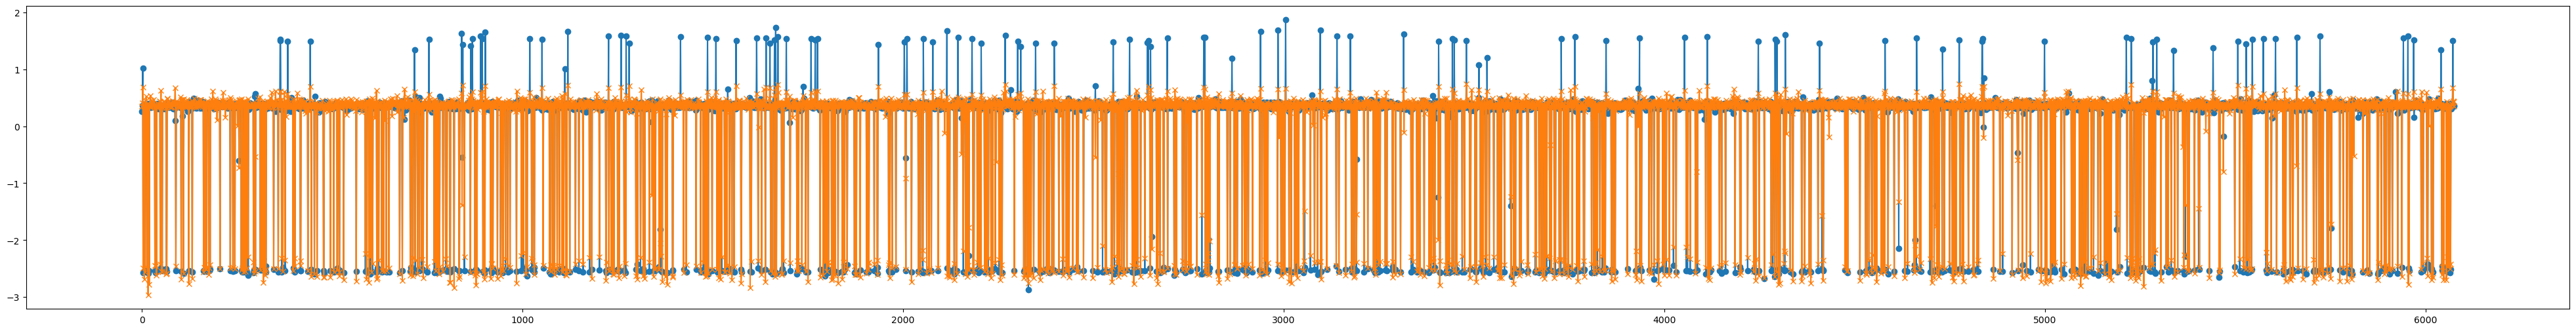

In [114]:
plt.figure(figsize=(50, 6))
plt.plot(y_train, marker="o")
plt.plot(y_pred_train, marker="x")
plt.show()

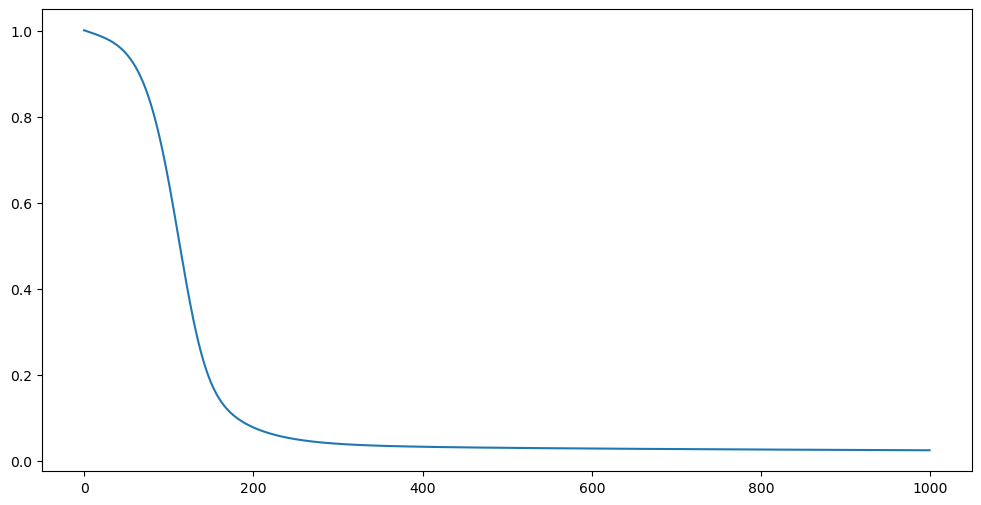

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(loss_list)
plt.show()

# Evaluate the Model on the Test Set

1.7869915312849183


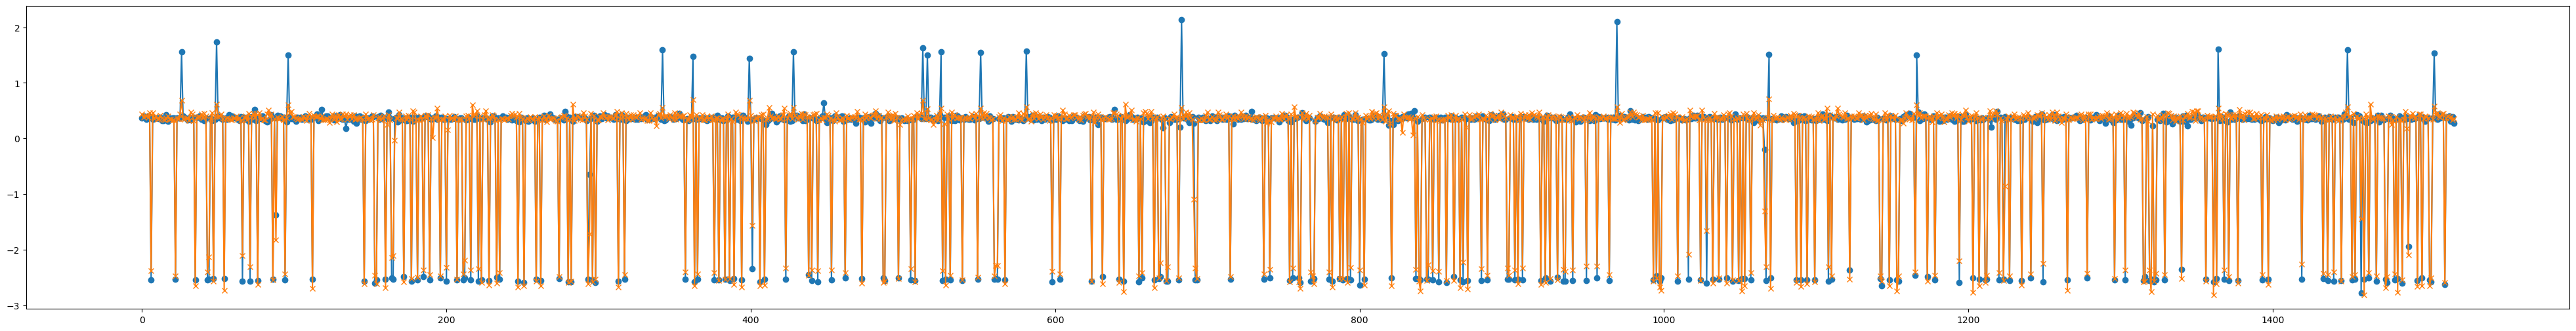

In [117]:
test_loss, y_pred_test = mlp_model.evaluate(x_test, y_test)
print(test_loss)

plt.figure(figsize=(50, 6))
plt.plot(y_test, marker="o")
plt.plot(y_pred_test, marker="x")
plt.show()

In [119]:
def evaluate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    mse_value = mse(y_true, y_pred)
    rmse = np.sqrt(mse_value)
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r_square = 1 - (ss_residual / ss_total)
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse_value:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-square: {r_square:.4f}")

evaluate_metrics(y_test, y_pred_test)

MAE: 0.0774
MSE: 0.0272
RMSE: 0.1649
R-square: 0.9757
